#### Import Libraries

In [1]:
import numpy as np
import networkx as nx
import math
import time
from scipy.interpolate import UnivariateSpline
import osmnx as ox
import matplotlib.pyplot as plt

#### Define Functions Used in Code

In [2]:
def time_expand(graph, time_int_size, num_time_int):
    start = time.time()
    orig_nodes = list(graph.nodes)
    orig_edges = list(graph.edges)
    ten = nx.MultiDiGraph()
    node_num = 1
    for j in range(num_time_int):
        for i in range(len(orig_nodes)):
            if graph._node[i]['orig_dest'] != None:
                orig_dest = graph._node[i]['orig_dest']
            else:
                orig_dest = 0
            node_name = f'{i}-{j}'
            ten.add_node(node_num, name = node_name, level = j, orig_dest = orig_dest)
            node_num += 1
    ###in the case of a multidigraph
    if graph.is_multigraph():
        node_num = 0
        for j in range(num_time_int-1):
            for i in range(len(orig_nodes)):
                ###keep track of node number for the overall network (need to account for nodes in the expansions)
                node_num +=1
                for k in range(len(orig_nodes)):
                    for m in range(graph.number_of_edges(i,k)+1):
                        ###check if edge exists in graph
                        if (i,k,m) in orig_edges:
                            ###deteremine how many time intervals it will cross
                            time_int_end = math.ceil(graph[i][k][m]['travel_time']/time_int_size)
                            ###check if the number it crosses exist in the network
                            if time_int_end+j< num_time_int:
                                ####add edge to time-expanded network
                                ten.add_edge(node_num,(node_num)+(k-i)+(len(orig_nodes)*time_int_end),cost = graph[i][k][m]['cost'] ,upper = graph[i][k][m]['upper'], lower = 0)
                            
    ###in the case of a digraph that is not a multdigraph
    elif graph.is_directed():
        node_num = 0
        for j in range(num_time_int-1):
            for i in range(len(orig_nodes)):
                ###keep track of node number for the overall network (need to account for nodes in the expansions)
                node_num +=1
                for k in range(len(orig_nodes)):
                    ###check if edge exists in graph
                    if (i,k) in orig_edges:
                        ###deteremine how many time intervals it will cross
                        time_int_end = math.ceil(graph[i][k]['travel_time']/time_int_size)
                        ###check if the number it crosses exist in the network
                        if time_int_end+j< num_time_int:
                            ####add edge to time-expanded network
                            ten.add_edge(node_num,(node_num)+(k-i)+(len(orig_nodes)*time_int_end),cost = graph[i][k]['cost'] ,upper = graph[i][k]['upper'], lower = 0)
    else:
        raise Exception("Must Input a DiGraph or MultiDiGraph")
        
    
    end = time.time()
    ###used for checking how long larger networks/expansions take to construct
    if end-start > 1:
        print('Number of Time Intervals:', num_time_int)
        print('Elasped Time: ',end-start, ' seconds')
    return ten

In [3]:
MOORE_AFTER_BREAK_SPLINE = UnivariateSpline(
    [20, 30, 40, 50, 60, 70, 80, 90, 100],
    [3.9, 6, 11, 18, 27, 39, 54, 58, 84],
)
MOORE_BEFORE_BREAK_SPLINE = UnivariateSpline(
    [20, 30, 40, 50, 60, 70, 80, 90, 100],
    [6, 8, 11, 14, 17, 19, 22, 25, 28],
)

MOORE_SAFE_BREAKING_DISTANCE = lambda x: MOORE_AFTER_BREAK_SPLINE(
    x
) + MOORE_BEFORE_BREAK_SPLINE(x)

def moore(lanes: float, max_speed: float):
    return 1000 * max_speed / MOORE_SAFE_BREAKING_DISTANCE(max_speed) * lanes

def add_capacities(G, method=moore):

    G = G.copy()
    cap = []
    
    for u, v, i in G.edges:
        edge_data = G.get_edge_data(u, v, i)
        raw_lanes = edge_data.get("lanes")
        
        if raw_lanes is None:
            lanes = 1
            
        elif isinstance(raw_lanes, str):
            lanes = int(raw_lanes) / 2  
            
        elif isinstance(raw_lanes, list):
            lanes = sum(int(x) for x in raw_lanes) / 2
            
        G[u][v][i]["upper"] = int(method(lanes, edge_data["speed_kph"]))
    return G

In [4]:
def add_costs(G, costs = 0):
    for u,v,i in G.edges:
        G[u][v][i]['cost'] = costs
    return G

In [5]:
def add_orig_dest(G, orig_dest = 0):
    for i in G.nodes:
        G._node[i]['orig_dest'] = orig_dest
    return G

### Toy Network Constructed

In [6]:
toy_net = nx.DiGraph()
toy_net.add_nodes_from(range(4))
toy_net.add_edges_from([(0,1),(0,2),(1,2),(1,3),(2,3)], cost = 0)
toy_net[0][1]['travel_time'] = 4
toy_net[0][2]['travel_time'] = 2
toy_net[1][2]['travel_time'] = 3
toy_net[1][3]['travel_time'] = 1
toy_net[2][3]['travel_time'] = 1
toy_net[0][1]['upper'] = 3
toy_net[0][2]['upper'] = 4
toy_net[1][2]['upper'] = 3
toy_net[1][3]['upper'] = 2
toy_net[2][3]['upper'] = 4
toy_net.nodes[0]['orig_dest'] = 1
toy_net.nodes[1]['orig_dest'] = 0
toy_net.nodes[2]['orig_dest'] = 0
toy_net.nodes[3]['orig_dest'] = -1
toy_net.nodes[0]['sup_dem'] = 9
toy_net.nodes[1]['sup_dem'] = 0
toy_net.nodes[2]['sup_dem'] = 0
toy_net.nodes[3]['sup_dem'] = 9

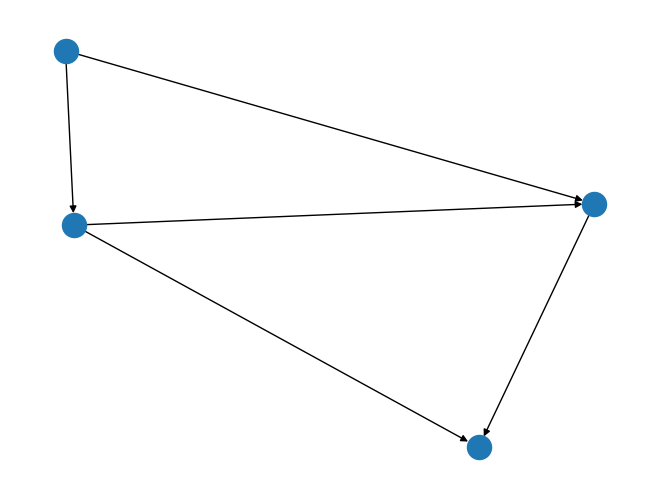

In [7]:
nx.draw(toy_net)

### Real-world Network Constructed

In [8]:
start = time.time()
#import data from osmnx, can input any city, state, etc.
G = ox.project_graph(ox.graph_from_place('Lyons Colorado', network_type='drive'))
print('Importing Network Complete')

#get rid of intersections that are not actually intersections
G = ox.simplification.consolidate_intersections(G, tolerance=10, rebuild_graph=True, dead_ends=True, reconnect_edges = True)
print('Simplication Complete')
#add edge speeds
G = ox.speed.add_edge_speeds(G)
print('Speed Added')

#add travel times
G = ox.speed.add_edge_travel_times(G)
print('Travel Time Added')

#add capacities (computed using moore method)
G = add_capacities(G)
print('Capacities Added')

G = add_costs(G)
print('Costs Added')

G = add_orig_dest(G)
print('Supply and Demand Values Added')

end = time.time()

print('Time to Build Original Network: ',end-start, ' seconds')

#G changes, so we want to have an original network to later plot the shortest paths on
# G_original=G.copy()

Importing Network Complete
Simplication Complete
Speed Added
Travel Time Added
Capacities Added
Costs Added
Supply and Demand Values Added
Time to Build Original Network:  1.5316894054412842  seconds


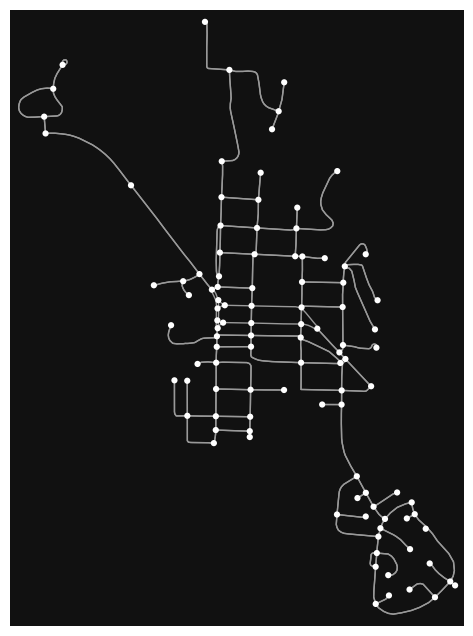

In [9]:
fig,ax = ox.plot_graph(G,show = False, close = False,node_size = 20)
plt.show()

### Test Time Expansion Functionality

In [10]:
test_copies = 5
test_time_int = 1
test_rw_copies = 3
test_rw_int = 5

In [11]:
test_ten = time_expand(toy_net,test_time_int,test_copies)

In [12]:
test_rw_net = time_expand(G,test_rw_int,test_rw_copies)

#### Draw Time Expanded Network (TEN)

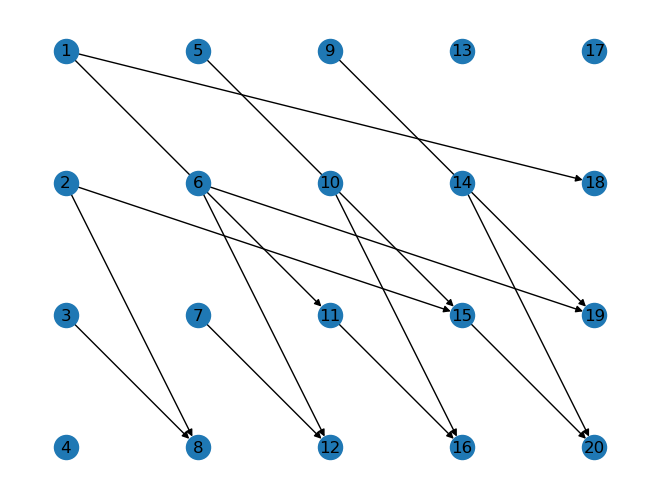

In [13]:
pos = nx.multipartite_layout(test_ten, subset_key="level")
nx.draw(test_ten, pos, with_labels=True)

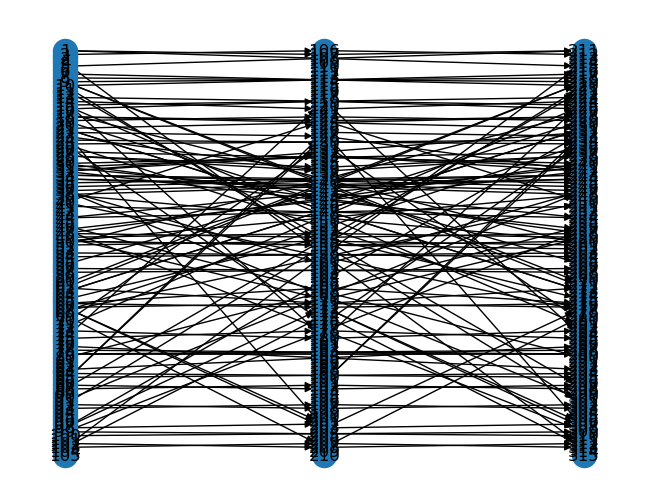

In [14]:
pos = nx.multipartite_layout(test_rw_net, subset_key="level")
nx.draw(test_rw_net, pos, with_labels=True)

#### Add Single Source and Sink Testing

In [15]:
def add_s_t(orig_graph, ten_graph, num_time_int, M):
    orig_nodes = list(orig_graph.nodes)
    ten_nodes = list(ten_graph.nodes)
    
    s = 0
    t = len(ten_nodes)+1
    
    ten_graph.add_node(s, level = 0)
    ten_graph.add_node(t, level = num_time_int-1)
    
    for i in range(len(orig_nodes)):
        j = 0
        if orig_graph._node[i]['orig_dest'] == 1:
            j = i+1
            while j <= t-1:
                ten_graph.add_edge(s, j, cost = 0, upper = M, lower = 0)
                j += len(orig_nodes)
        elif orig_graph._node[i]['orig_dest'] == -1:
            j = i+1
            while j <= t-1:
                ten_graph.add_edge(j,t, cost = 0, upper = M, lower = 0)
                j += len(orig_nodes)
                
    return ten_graph

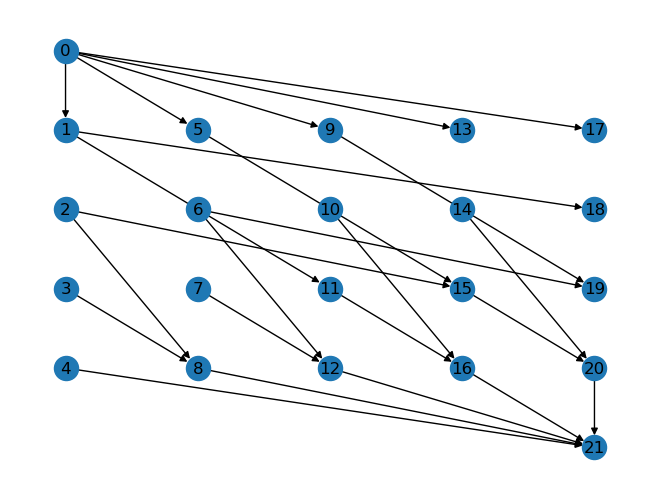

In [16]:
test_ten = time_expand(toy_net,test_time_int,test_copies)
test_ten_copy = test_ten.copy()
max_flow_ten = add_s_t(toy_net,test_ten_copy, test_copies,1000)
pos = nx.multipartite_layout(test_ten, subset_key="level")
pos[0]= np.array([pos[1][0],pos[1][1]+(pos[1][1]-pos[2][1])])
pos[len(list(max_flow_ten.nodes))-1] = np.array([pos[len(list(max_flow_ten.nodes))-2][0],pos[len(list(max_flow_ten.nodes))-2][1]-(pos[len(list(max_flow_ten.nodes))-3][1]-pos[len(list(max_flow_ten.nodes))-2][1])])

nx.draw(max_flow_ten, pos, with_labels = True)

### Max Flow Algorithm Testing

In [17]:
###note that this function does not account for the cost of each edge, just the capacity
def simplify_multigraph(graph):
    num_nodes = len(graph.nodes)
    edges = graph.edges
    
    simp_graph = nx.DiGraph()
    simp_graph.add_nodes_from(graph.nodes(data=True))
    
    for i in range(num_nodes+1):
        for j in range(num_nodes+1):
            if (i,j) in edges:
                num_edges = graph.number_of_edges(i,j)
                tot_cap = graph[i][j][num_edges-1]['upper']
                if num_edges > 1:
                    for k in range(1,num_edges):
                        tot_cap = tot_cap + graph[i][j][k]['upper']
                simp_graph.add_edge(i,j, upper = tot_cap, lower = 0)
            
    return simp_graph

In [18]:
def color_max_flow(graph, flow_dict):
    num_nodes = len(graph.nodes)
    edges = graph.edges
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if (i,j) in edges:
                graph[i][j]['color'] = (0,0,0)
                if flow_dict[i][j] != 0:
                    graph[i][j]['color'] = (1,0,0)
                    
    return graph

### Finding Number of Time Intervals for Total Evacuation

In [19]:
def det_num_int(G):
    pop = 20
    flow_value = 0

    time_int_len = 1
    num_time_ints = 1 ###time zero

    while flow_value < pop:
        ten = nx.MultiDiGraph()
        simp_tem = nx.DiGraph()
        max_flow_ten = nx.DiGraph()
        num_time_ints +=1
        
        ten = time_expand(G,time_int_len,num_time_ints)
        simp_ten = simplify_multigraph(ten)
        max_flow_ten = add_s_t(G, simp_ten, num_time_ints,1000)
        flow_value, flow_dict = nx.maximum_flow(max_flow_ten, 0, len(list(max_flow_ten.nodes))-1,capacity = 'upper')
        
    
    colored_max_flow_ten = color_max_flow(max_flow_ten,flow_dict)
    num_nodes = len(list(colored_max_flow_ten))
    pos = nx.multipartite_layout(ten, subset_key="level")
    pos[0]= np.array([pos[1][0],pos[1][1]+(pos[1][1]-pos[2][1])])
    pos[num_nodes-1] = np.array([pos[num_nodes-2][0],pos[num_nodes-2][1]-(pos[num_nodes-3][1]-pos[num_nodes-2][1])])
    colors = [colored_max_flow_ten[u][v]['color'] for u,v in colored_max_flow_ten.edges]
    nx.draw(colored_max_flow_ten, pos, edge_color=colors,with_labels = True)
    
    return (num_time_ints, flow_value, colored_max_flow_ten)      

Number of Time Intervals: 7
Flow Value: 20


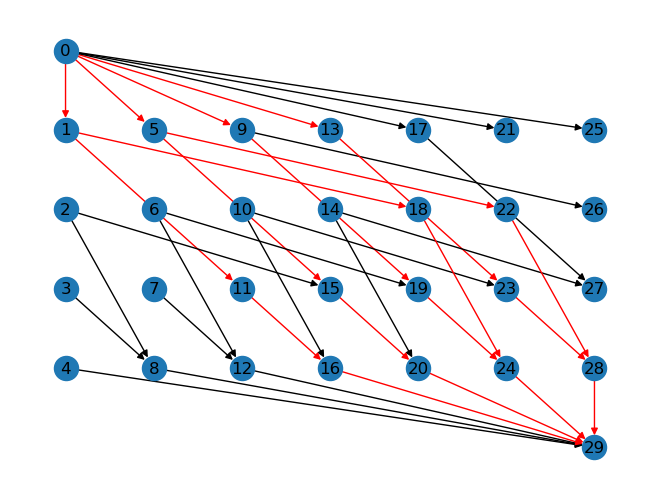

In [20]:
num_time_ints, max_flow, toy_net_test = det_num_int(toy_net)
print('Number of Time Intervals:',num_time_ints)
print('Flow Value:', max_flow)

### Nick's Fire Polygon Code

In [21]:
import shapefile as shapefile
#This reads in the shapefile
sf = shapefile.Reader("blockgroups.shp")

#this tells us what type of "shape" is in our shapefile
s=sf.shapeTypeName
print(s)

#this gives us the coordinates of the boundary box of our shape file
sh=sf.bbox
print(sh)

# creating the list of lat/long
test_list = sh

# Making the lat/long points
long = [test_list[i] for i in range(len(sh)) if i % 2 != 0]
lat = [test_list[i] for i in range(len(sh)) if i % 2 == 0]

# printing result
print("The alternate element list is : " + str(long))
print("The alternate element list is : " + str(lat))

POLYGON
[-122.515048, 37.652916, -122.327622, 37.863433]
The alternate element list is : [37.652916, 37.863433]
The alternate element list is : [-122.515048, -122.327622]
